# Lending Club and S&P 500 Data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
%matplotlib inline

#### Lending Club return

In [2]:
# reading the 'All Payments' csv file
path = Path("PMTHIST_ALL_201910.csv")
df = pd.read_csv(path, usecols=['LOAN_ID','PBAL_BEG_PERIOD','INT_PAID','FEE_PAID','MONTH','COAMT','IssuedDate','grade', 'term','PCO_RECOVERY', 'PCO_COLLECTION_FEE'])
df.head(3)

,LOAN_ID,PBAL_BEG_PERIOD,INT_PAID,FEE_PAID,MONTH,COAMT,IssuedDate,grade,term,PCO_RECOVERY,PCO_COLLECTION_FEE
0,54734,25000.000000,247.802083,0.0,SEP2009,0.0,AUG2009,B,36,NaN,NaN
1,54734,24418.702083,242.040210,0.0,OCT2009,0.0,AUG2009,B,36,NaN,NaN
2,54734,23831.642293,236.221224,0.0,NOV2009,0.0,AUG2009,B,36,NaN,NaN


In [3]:
# filter loans issued in 2016-2017
df_16_17 = df[df.IssuedDate.str.contains("2016|2017")]

In [4]:
# Grouping the data by 'grade', 'term' and 'month' and summing the balances of all loans in these buckets
df_agg = df_16_17.groupby(['grade', 'term','MONTH']).sum()[['PBAL_BEG_PERIOD','INT_PAID','FEE_PAID','COAMT','PCO_RECOVERY', 'PCO_COLLECTION_FEE']]

In [5]:
# cash to investor = interest - fee to Lending Club - charge off amount + recovered amount - collection fee
# monthly return = cash to investor/begininng period principal balance

df_agg['CASH_INVESTOR'] = df_agg.INT_PAID - df_agg.FEE_PAID - df_agg.COAMT + df_agg.PCO_RECOVERY - df_agg.PCO_COLLECTION_FEE 
df_agg['MNTHLY_RETURN'] = df_agg.CASH_INVESTOR/df_agg.PBAL_BEG_PERIOD

In [6]:
# creating return column for all grade-term buckets

df_agg.index = df_agg.index.set_levels([df_agg.index.levels[0],df_agg.index.levels[1], pd.to_datetime(df_agg.index.levels[2])])
df_agg.sort_index(inplace=True)
loan_ret = df_agg.MNTHLY_RETURN.to_frame()
loan_ret = loan_ret.unstack(level = [0,1])
loan_ret.head(3)

MNTHLY_RETURN                                                    \
grade                  A                   B                   C             
term                  36        60        36        60        36        60   
MONTH                                                                        
2016-01-01      0.001292  0.003552  0.002079  0.001896  0.003615  0.004543   
2016-02-01      0.005659  0.006529  0.008186  0.008378  0.010962  0.011253   
2016-03-01      0.005606  0.006312  0.008277  0.008360  0.011133  0.011354   

                                                                        \
grade              D                   E                   F             
term              36        60        36        60        36        60   
MONTH                                                                    
2016-01-01  0.004709  0.005066  0.006276  0.004827  0.006873  0.008048   
2016-02-01  0.014054  0.014323  0.016160  0.016589  0.018375  0.019852   
2016-03-01  0.014277  0.014626  0.016825  0.016997  0.019922  0.019873   

                                
grade              G            
term              36        60  
MONTH                           
2016-01-01  0.003878  0.010466  
2016-02-01  0.021850  0.022619  
2016-03-01  0.020686  0.022778

#### S&P 500 return

In [7]:
# reading the S&P 500 monthly data csv file
SP_500 = pd.read_csv("SP_500.csv", index_col='Date', infer_datetime_format=True, parse_dates= True)
SP_500 = SP_500.Close[:'2019-09'].to_frame()
SP_500['RET_SP_500']=SP_500.Close.pct_change()
SP_500.dropna(inplace=True)
SP_500.drop(columns = 'Close', inplace= True)
SP_500.head(3)

,RET_SP_500
Date,
2016-01-01,-0.050735
2016-02-01,-0.004128
2016-03-01,0.065991


#### Lending Club and S&P returns data combined

In [23]:
#joining the dataframes
all_assets = pd.concat([loan_ret,SP_500], axis = 1)
#renaming the columns
all_assets.columns = ['A-3', 'A-5', 'B-3','B-5','C-3', 'C-5', 'D-3','D-5','E-3', 'E-5', 'F-3','F-5','G-3', 'G-5', 'SP_500']
all_assets.head()

,A-3,A-5,B-3,B-5,C-3,C-5,D-3,D-5,E-3,E-5,F-3,F-5,G-3,G-5,SP_500
2016-01-01,0.001292,0.003552,0.002079,0.001896,0.003615,0.004543,0.004709,0.005066,0.006276,0.004827,0.006873,0.008048,0.003878,0.010466,-0.050735
2016-02-01,0.005659,0.006529,0.008186,0.008378,0.010962,0.011253,0.014054,0.014323,0.016160,0.016589,0.018375,0.019852,0.021850,0.022619,-0.004128
2016-03-01,0.005606,0.006312,0.008277,0.008360,0.011133,0.011354,0.014277,0.014626,0.016825,0.016997,0.019922,0.019873,0.020686,0.022778,0.065991
2016-04-01,0.005523,0.006168,0.008310,0.008370,0.011186,0.011398,0.014428,0.014801,0.016885,0.017163,0.020103,0.020173,0.023133,0.022702,0.002699
2016-05-01,0.005485,0.006215,0.008218,0.008356,0.011195,0.011397,0.014553,0.014853,0.017112,0.017359,0.019912,0.019319,0.022691,0.022320,0.015325


# Returns

#### Mean returns for each asset during the given period

In [9]:
# mean return in percentage
mean_returns = all_assets.mean()*12*100
mean_returns

A-3        4.606971
A-5        5.353015
B-3        4.921168
B-5        6.863737
C-3        4.246341
C-5        7.864461
D-3        3.246384
D-5        7.713229
E-3        1.277363
E-5        6.157324
F-3       -2.673403
F-5        3.056749
G-3       -6.770392
G-5        2.914173
SP_500    10.762329
dtype: float64

Text(0, 0.5, 'Return (%)')

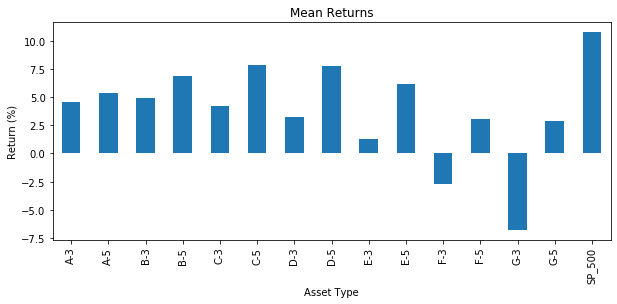

In [10]:
ax = mean_returns.plot(kind = 'bar',figsize = (10,4) , title= 'Mean Returns')
ax.set_xlabel("Asset Type")
ax.set_ylabel("Return (%)")

#### Cumulative return graph from grade A, B, C and D and S&P 500 

In [41]:
#calculating cumulative returns for each asset in percentage terms(%)
cum_ret = ((1+all_assets[['A-3', 'A-5', 'B-3','B-5','C-3', 'C-5', 'D-3','D-5','SP_500']]).cumprod()-1)*100
cum_ret.head()

,A-3,A-5,B-3,B-5,C-3,C-5,D-3,D-5,SP_500
2016-01-01,0.129230,0.355160,0.207868,0.189602,0.361511,0.454288,0.470948,0.506589,-5.073532
2016-02-01,0.695875,1.010340,1.028138,1.028963,1.461681,1.584728,1.882946,1.946176,-5.465423
2016-03-01,1.260361,1.647915,1.864300,1.873533,2.591208,2.738080,3.337494,3.437268,0.773019
2016-04-01,1.819624,2.274911,2.710825,2.726251,3.738750,3.909138,4.828448,4.968204,1.045046
2016-05-01,2.378142,2.910555,3.554864,3.584670,4.900103,5.093435,6.354058,6.527298,2.593521


Text(0, 0.5, 'Cumulative Return (%)')

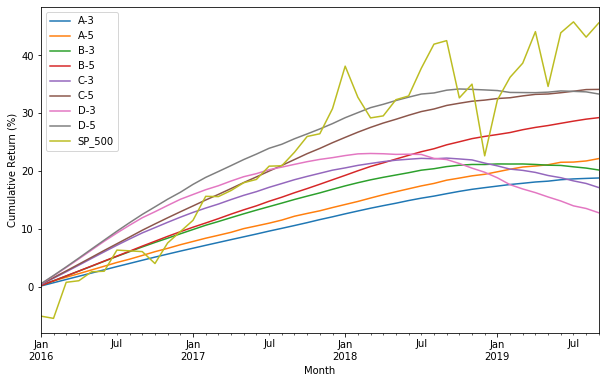

In [42]:
ax = cum_ret.plot(figsize = (10,6))
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative Return (%)")

# Sharpe Ratio based performance analysis 

In [13]:
# taking one month Treasury rate as risk free rate
rfr = 0.0158
#calculating annual Sharpe Ratio
sharpe_ratio = (all_assets.mean() * 12 - rfr) / (all_assets.std() * np.sqrt(12))
sharpe_ratio.rename("Sharpe Ratio", inplace = True)
sharpe_ratio

A-3       6.044642
A-5       7.466764
B-3       2.967332
B-5       7.468533
C-3       1.461706
C-5       5.122919
D-3       0.655585
D-5       3.313572
E-3      -0.095473
E-5       1.968854
F-3      -1.014541
F-5       0.477528
G-3      -1.301448
G-5       0.353791
SP_500    0.774099
Name: Sharpe Ratio, dtype: float64

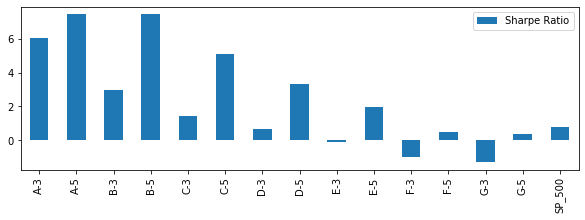

In [14]:
sharpe_ratio.plot(kind = 'bar',figsize = (10,3), legend = True)

# Across asset correlation analysis

In [15]:
# calculating cross-asset correlation matrix
correlation = all_assets.corr()
correlation

,A-3,A-5,B-3,B-5,C-3,C-5,D-3,D-5,E-3,E-5,F-3,F-5,G-3,G-5,SP_500
A-3,1.000000,0.876492,0.967298,0.967656,0.913146,0.934575,0.852109,0.899011,0.834505,0.802053,0.709236,0.693940,0.612279,0.667513,0.154323
A-5,0.876492,1.000000,0.907337,0.867281,0.876503,0.872737,0.836405,0.860080,0.810046,0.799736,0.716271,0.735960,0.616825,0.686228,0.214548
B-3,0.967298,0.907337,1.000000,0.963376,0.978062,0.981666,0.937704,0.962922,0.905735,0.890751,0.794631,0.802188,0.688542,0.756088,0.136214
B-5,0.967656,0.867281,0.963376,1.000000,0.944423,0.964488,0.906208,0.940713,0.873409,0.875949,0.755170,0.775781,0.658365,0.736586,0.149617
C-3,0.913146,0.876503,0.978062,0.944423,1.000000,0.988887,0.980291,0.981705,0.956292,0.942981,0.856803,0.882646,0.744010,0.835467,0.110200
C-5,0.934575,0.872737,0.981666,0.964488,0.988887,1.000000,0.967212,0.974714,0.939184,0.925247,0.817888,0.848698,0.749862,0.811821,0.140323
D-3,0.852109,0.836405,0.937704,0.906208,0.980291,0.967212,1.000000,0.982552,0.965168,0.965155,0.892067,0.927609,0.784181,0.867322,0.071418
D-5,0.899011,0.860080,0.962922,0.940713,0.981705,0.974714,0.982552,1.000000,0.946174,0.955088,0.869757,0.900955,0.725841,0.836359,0.109550
E-3,0.834505,0.810046,0.905735,0.873409,0.956292,0.939184,0.965168,0.946174,1.000000,0.942827,0.895469,0.916299,0.814440,0.901211,0.098593
E-5,0.802053,0.799736,0.890751,0.875949,0.942981,0.925247,0.965155,0.955088,0.942827,1.000000,0.873731,0.965402,0.740429,0.889326,0.147592


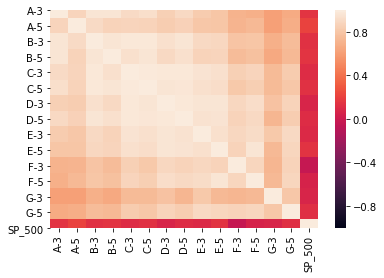

In [16]:
# heat-map for visual presentation of correlation matrix
sns.heatmap(correlation, vmin=-1, vmax=1)

#### Each of the loan grades have very low correlation with S&P 500

# Recommendations (Portfolio Planner) : Combining Lending Club Loans with S&P 500

#### Here we can set any desired weight to different assets in the portfolio

In [24]:
# setting portfolio weights
portfolio_weights = [0.0, 0.0, 0.2, 0.2, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6]
portfolio_returns = all_assets.dot(portfolio_weights)
portfolio_returns.head()

2016-01-01   -0.029646
2016-02-01    0.000836
2016-03-01    0.042922
2016-04-01    0.004956
2016-05-01    0.012510
dtype: float64

In [25]:
# calculating cumulative return of the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()
cumulative_returns.head()

2016-01-01    0.970354
2016-02-01    0.971165
2016-03-01    1.012849
2016-04-01    1.017868
2016-05-01    1.030601
dtype: float64

In [26]:
# annualized mean of portfolio returns (%)
portfolio_ret_mean = portfolio_returns.mean()*12*100
portfolio_ret_mean

8.814378078444465

In [27]:
# annualized standard deviation of the portfolio returns (%)
portfolio_ret_std = portfolio_returns.std()*np.sqrt(12)*100
portfolio_ret_std

7.178038616106819

Text(0, 0.5, 'Portfolio Dollar Value')

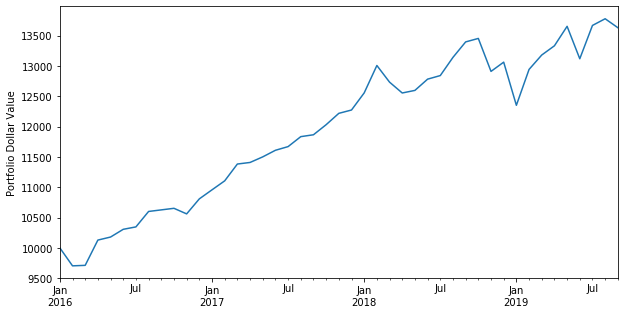

In [40]:
# how much money we would make by investing in this portfolio!!
initial_investment = 10000
cumulative_profit = initial_investment * cumulative_returns.shift(1)
cumulative_profit['2016-01-01'] = 10000
ax = cumulative_profit.plot(figsize = (10,5))
ax.set_ylabel("Portfolio Dollar Value")